In [ ]:
"""
Basic sentiment analysis

1. nltk (VADER)
2. TextBlob

"""

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

## 1. Load data

In [103]:
# Let's read in our document-term matrix
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_df_raw = pd.read_pickle('../dump/speech_df')
data = pd.read_pickle('../dump/data_dtm_lemma.pkl')
tdm = data.transpose()

In [7]:
speech_df.head()

,speaker,year,transcript,length
0,SIDDHARTHA MUKHERJEE,2018,i wish someone have tell me at my own commence...,14487
1,ABBY WAMBACK,2018,failure be not something to be ashamed of its ...,15866
2,JON B. FISHER,2018,thank you very much my father commencement spe...,8544
3,MINDY KALING,2018,good morning to the class of the faculty the p...,15391
4,JESMYN WARD,2018,persist be patient be well good morning it be ...,14063


## 2. VADER
Valence Aware Dictionary for Sentiment Reasoning

* polarity (positive/negative)
* intensity (strength) of emotion
* coumpound score: sum of all the lexicon ratings

In [8]:
# Instantiate the analyzer
analyzer = SIA()

In [13]:
# Test sentence
analyzer.polarity_scores('The phone is super cool')

{'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}

In [19]:
# Test sentence with punctuation
analyzer.polarity_scores('The phone is super cool!!!')

{'neg': 0.0, 'neu': 0.298, 'pos': 0.702, 'compound': 0.795}

### A. Overall polarity

In [43]:
# Create vader_df

results = []
for i in range(len(speech_df)):
    test = speech_df.transcript.iloc[i]
    ana = analyzer.polarity_scores(test)
    results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

In [44]:
vader_df = pd.DataFrame(results,columns=['neg','neu','pos','compound'])
vader_df

,neg,neu,pos,compound
0,0.088,0.810,0.102,0.9599
1,0.095,0.785,0.120,0.9984
2,0.038,0.821,0.141,0.9995
3,0.072,0.777,0.151,0.9998
4,0.084,0.768,0.148,0.9996
...,...,...,...,...
436,0.069,0.830,0.101,0.9993
437,0.085,0.764,0.151,0.9996
438,0.082,0.749,0.168,0.9998
439,0.079,0.714,0.207,1.0000


In [57]:
# vader_df.neg.mean(),vader_df.neu.mean(),vader_df.pos.mean(),vader_df.compound.mean()

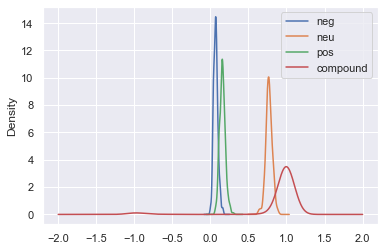

In [56]:
vader_df.plot.kde();
# plt.xlim(-1, 1);

In [64]:
# vader_df.hist();

In [ ]:
# Overall, pos has a slightly higher mean than neg. Most (all?) speech transcripts are mostly neutral.

### B. Evolution of polarity in each speech

#### First try with tokenized words (from speech_clean_lemma)

In [109]:
test = speech_df.transcript.iloc[0]

# test

test_words = test.split(" ")

results_word = []
for word in test_words:
    ana = analyzer.polarity_scores(word)
    results_word.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

vader_word_df = pd.DataFrame(results_word,columns=['neg','neu','pos','compound'])
vader_word_df

,neg,neu,pos,compound
0,0.0,0.0,0.0,0.0000
1,0.0,0.0,1.0,0.4019
2,0.0,1.0,0.0,0.0000
3,0.0,1.0,0.0,0.0000
4,0.0,1.0,0.0,0.0000
...,...,...,...,...
2565,0.0,1.0,0.0,0.0000
2566,0.0,1.0,0.0,0.0000
2567,0.0,1.0,0.0,0.0000
2568,0.0,1.0,0.0,0.0000


In [98]:
def simple_plot(y,df,xlabel,ylabel,title):
    plt.plot(df.index,df[y])
    plt.title(title,fontsize=16)
    plt.ylabel(xlabel,fontsize=16)
    plt.xlabel(ylabel,fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

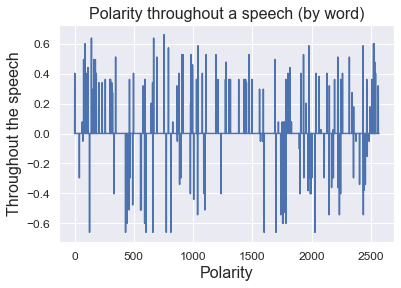

In [120]:
simple_plot('compound',vader_word_df,'Throughout the speech','Polarity','Polarity throughout a speech (by word)')

In [ ]:
# Too noisy.

#### Analyze sentiment based on sentences (from speech_df; before intense cleaning).

In [149]:
# Test with the first speech
test = speech_df_raw.transcript.iloc[0]
test_sents = test.split(".")
results_sent = []
for sent in test_sents:
    ana = analyzer.polarity_scores(sent)
    results_sent.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

vader_sent_df = pd.DataFrame(results_sent,columns=['neg','neu','pos','compound'])
vader_sent_df

,neg,neu,pos,compound
0,0.00,0.863,0.137,0.4019
1,0.00,0.000,0.000,0.0000
2,0.00,0.000,0.000,0.0000
3,0.00,1.000,0.000,0.0000
4,0.18,0.820,0.000,-0.2960
...,...,...,...,...
142,0.00,0.563,0.437,0.8519
143,0.00,1.000,0.000,0.0000
144,0.00,1.000,0.000,0.0000
145,0.00,0.730,0.270,0.3804


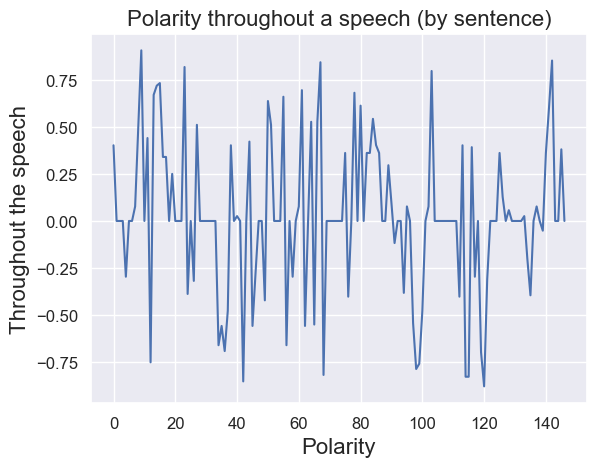

In [157]:
plt.rcParams.update(plt.rcParamsDefault)
sns.set()

simple_plot('compound',vader_sent_df,'Throughout the speech','Polarity','Polarity throughout a speech (by sentence)')

In [ ]:
# Still too noisy to get anything meaningful.

#### Analyze sentiment based on parts (sections).

In [227]:
# Split each speech into 10 parts

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [246]:
def polarity_speech(transcript):
    """
    Input: one transcript (with original punctuation)
    Output: polarity plot throughout the speech
    
    """
#     sents = transcript.split(".")
    
    sents = split_text(transcript, n=10)

    results = []
    for sent in sents:
        ana = analyzer.polarity_scores(sent)
        results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

    vader_sent_df = pd.DataFrame(results,columns=['neg','neu','pos','compound'])
    
    return simple_plot('compound',vader_sent_df,\
                'Polarity','',\
                title = '')

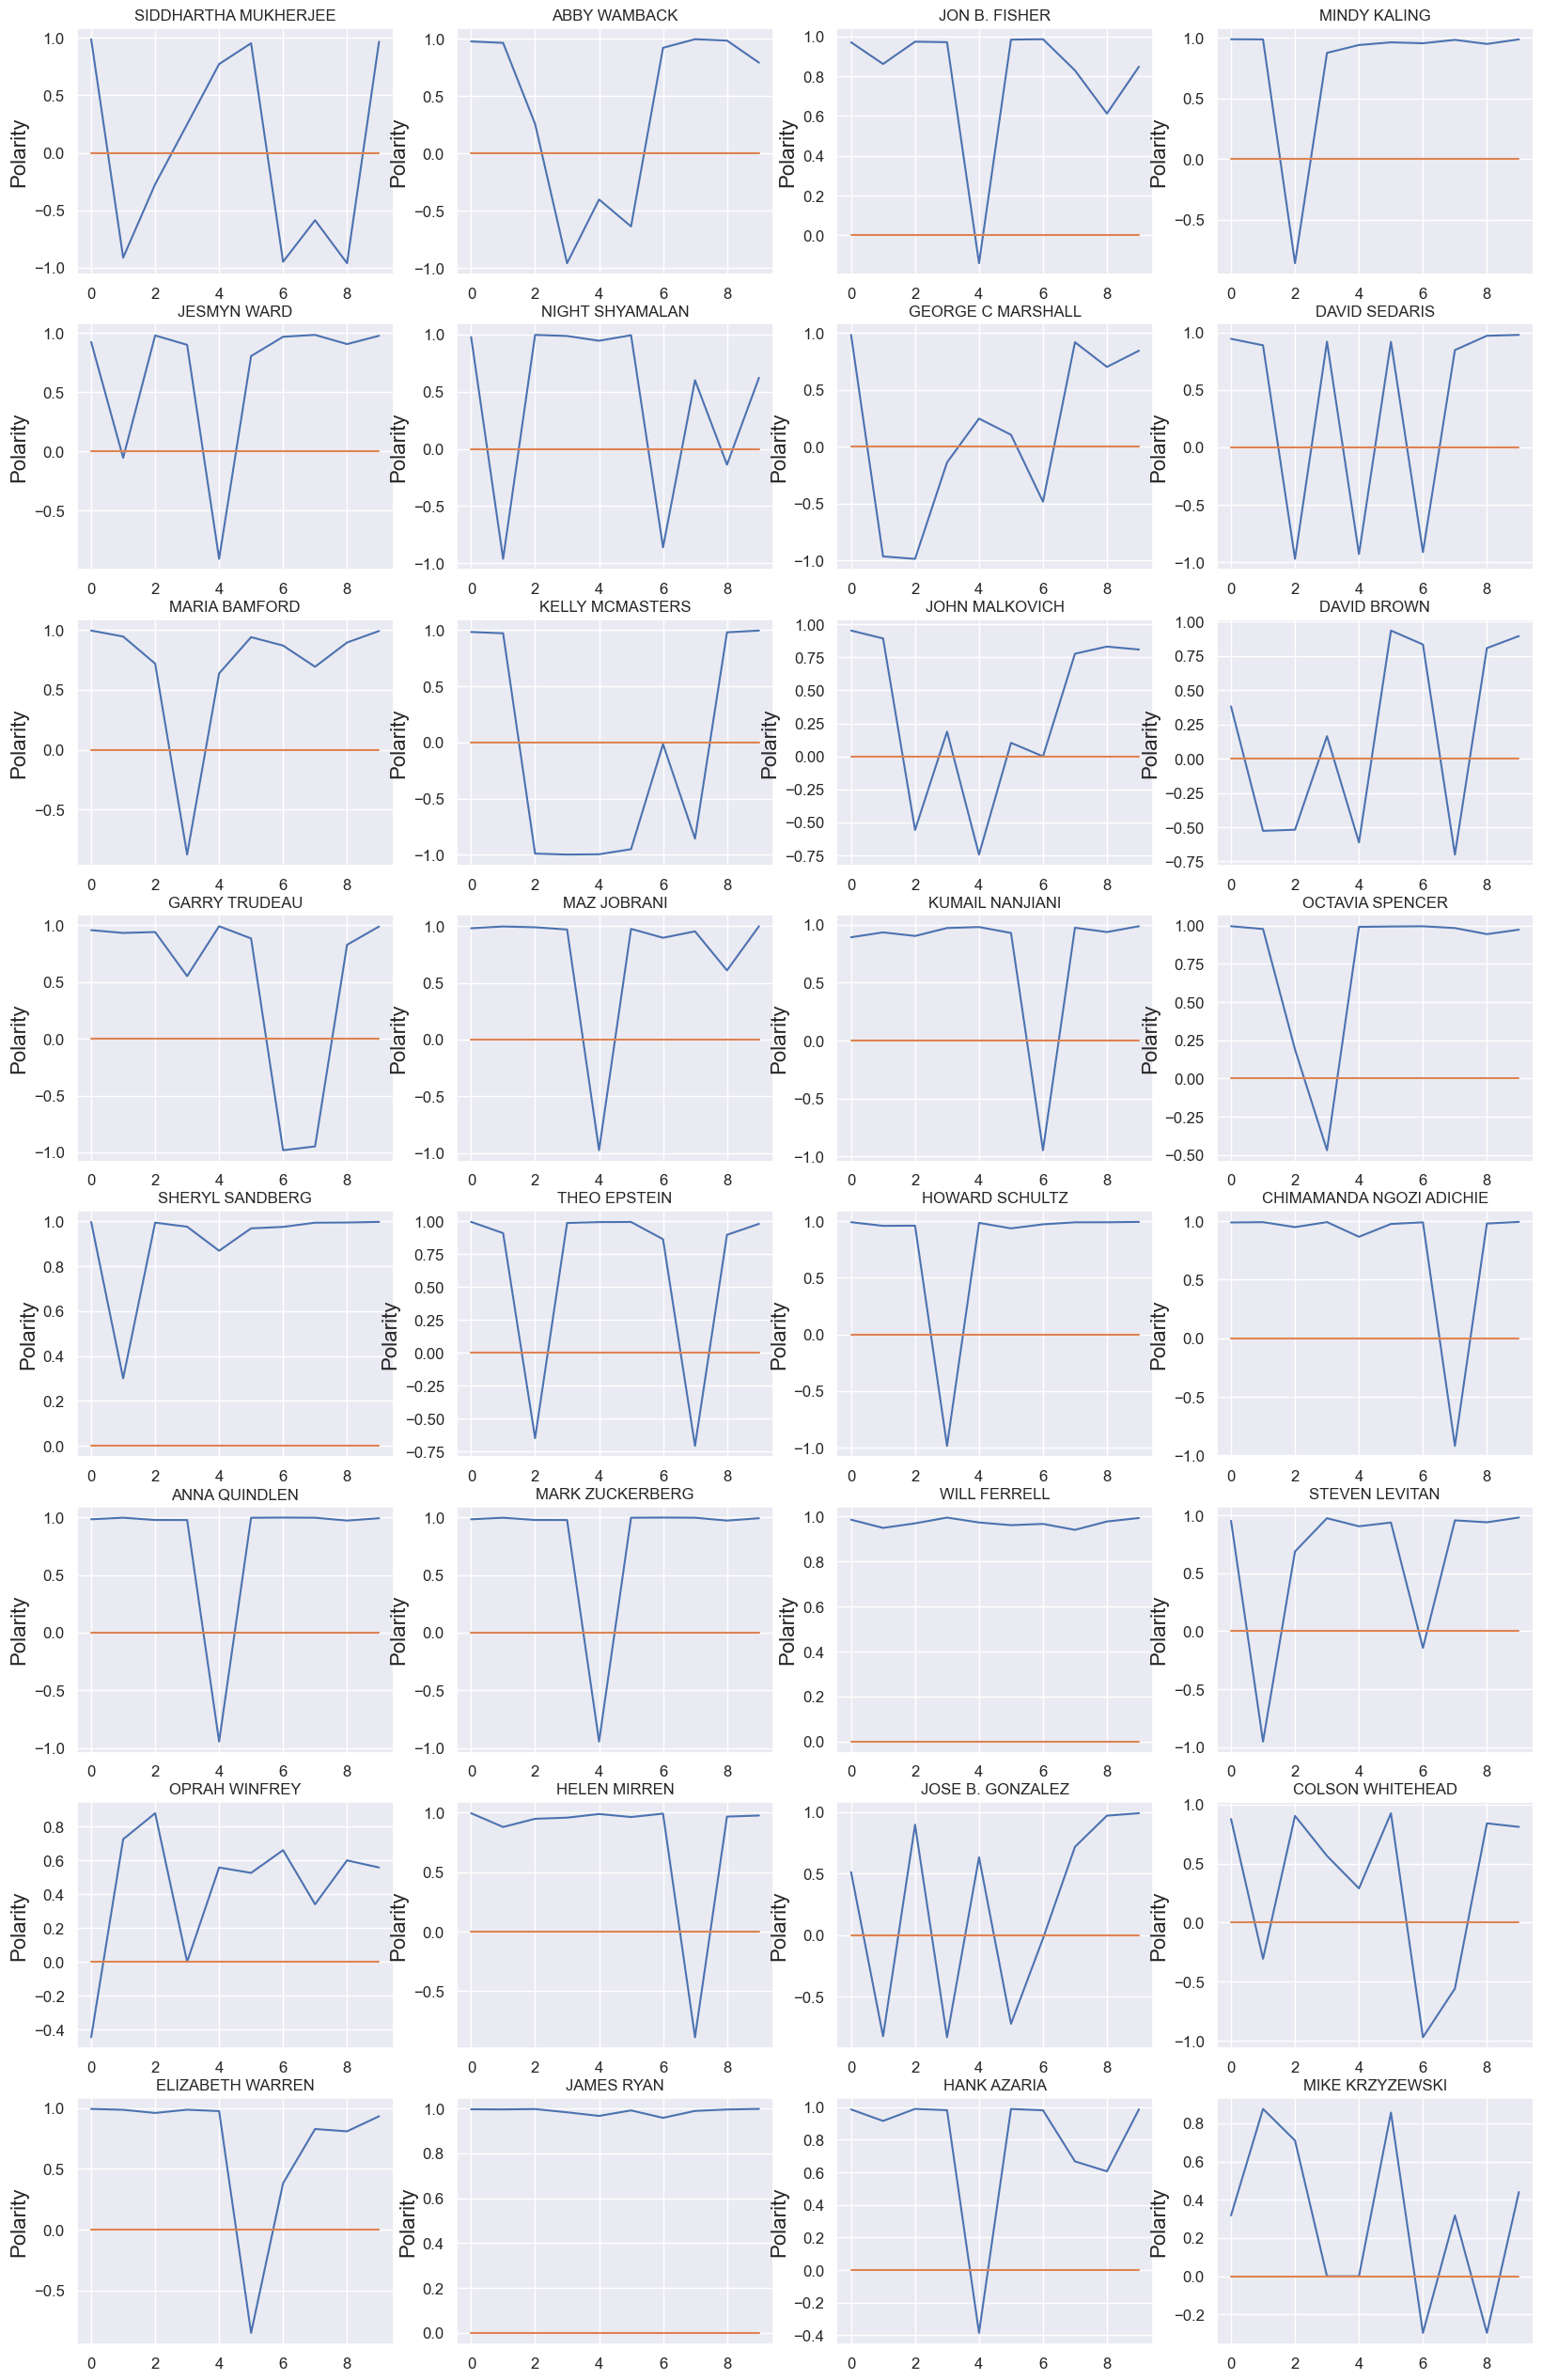

In [247]:
# Check the first 30 speeches

plt.rcParams['figure.figsize'] = [20, 32]

num_speech = 32
for i in range(num_speech):
    test = speech_df_raw.transcript.iloc[i]
    plt.subplot(num_speech//4,4,i+1)
    polarity_speech(test)
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(speech_df_raw.speaker.iloc[i])
    
    
plt.show()

## 3. TextBlob
(Following Alice Zhao's tutorial).

### A. Overall analysis (polarity, subjectivity)

In [160]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

speech_df_raw['polarity'] = speech_df_raw['transcript'].apply(pol)
speech_df_raw['subjectivity'] = speech_df_raw['transcript'].apply(sub)
speech_df_raw

,speaker,year,transcript,length,polarity,subjectivity
0,SIDDHARTHA MUKHERJEE,2018,I wish someone had told me at my own commenc...,14487,0.113403,0.453817
1,ABBY WAMBACK,2018,"Failure is not something to be ashamed of, ...",15866,0.015696,0.399591
2,JON B. FISHER,2018,\r\n Commencement Speech Transcript ...,8544,0.239356,0.454167
3,MINDY KALING,2018,"Good morning to the Class of 2018, the facul...",15391,0.163196,0.529258
4,JESMYN WARD,2018,Persist. Be patient. Be well. Good morning....,14063,0.105514,0.506782
...,...,...,...,...,...,...
436,CARRIE CHAPMAN,1936,I bring a message to Sweet Briar College and e...,22942,0.114812,0.434971
437,FRANKLIN D ROOSEVELT,1932,"For me, as for you, this is a day of honorable...",16017,0.115993,0.458075
438,OPRAH WINFREY,1918,Thank you Wallis Annenberg and a special thank...,15301,0.127203,0.493960
439,RALPH WALDO,1838,"In this refulgent summer, it has been a luxury...",40403,0.157895,0.523631


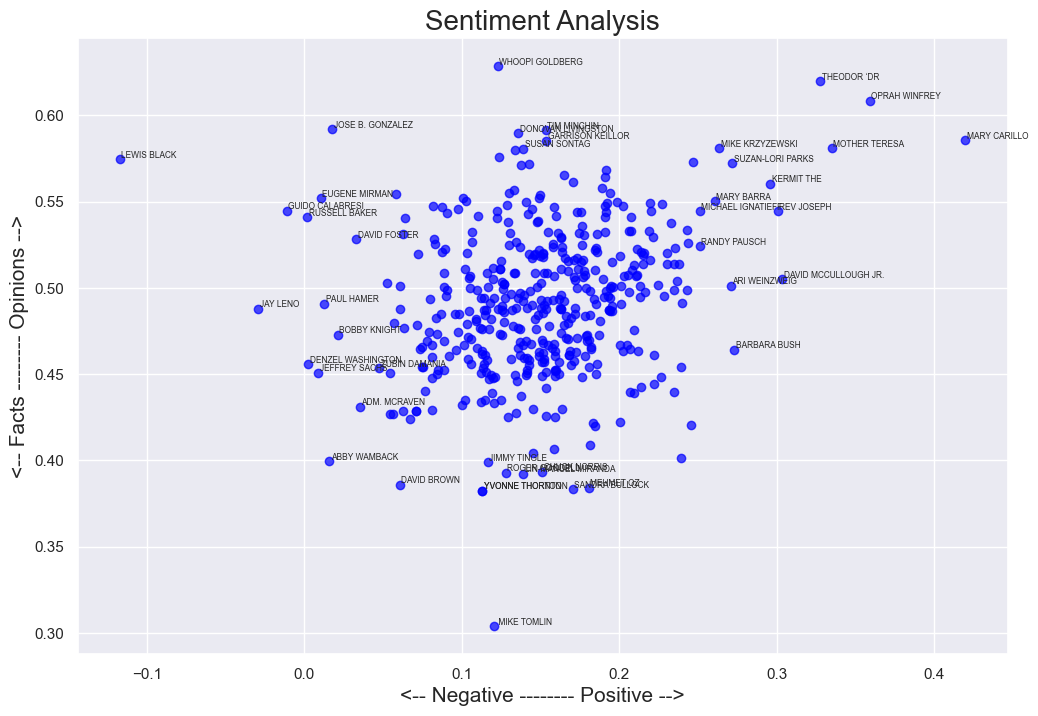

In [176]:
# Let's plot the results

plt.rcParams['figure.figsize'] = [12, 8]

for index, speech in enumerate(speech_df_raw.index):
    x = speech_df_raw.polarity.loc[speech]
    y = speech_df_raw.subjectivity.loc[speech]
    plt.scatter(x, y, color='blue',alpha=0.7)
    
    if (x>0.25) or (x<0.05) or (y>0.58) or (y<0.4):
        plt.text(x+.001, y+.001, speech_df_raw['speaker'][index], fontsize=6)
    
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
# plt.xlim(-.01, .45)

plt.show()

### B. Sentiment in each speech

In [177]:
# Split each routine into 10 parts
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [230]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
data = speech_df_raw
for t in data.transcript:
    split = split_text(t,10)
    list_pieces.append(split)

# 441 elements (speeches) in list_pieces
# Each element (speech) has 10 elements (sections)
len(list_pieces), len(list_pieces[0])

(441, 10)

In [231]:
# Calculate the polarity for each piece of text

polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)

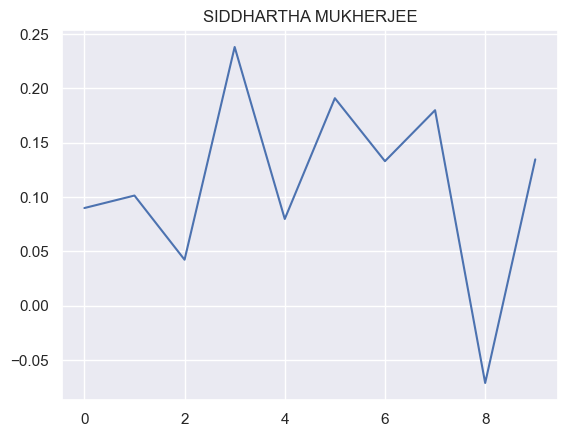

In [235]:
# Show the plot for one comedian
plt.rcParams.update(plt.rcParamsDefault)
sns.set()
plt.plot(polarity_transcript[0])
plt.title(data['speaker'].iloc[0])
plt.show()

In [233]:
# data

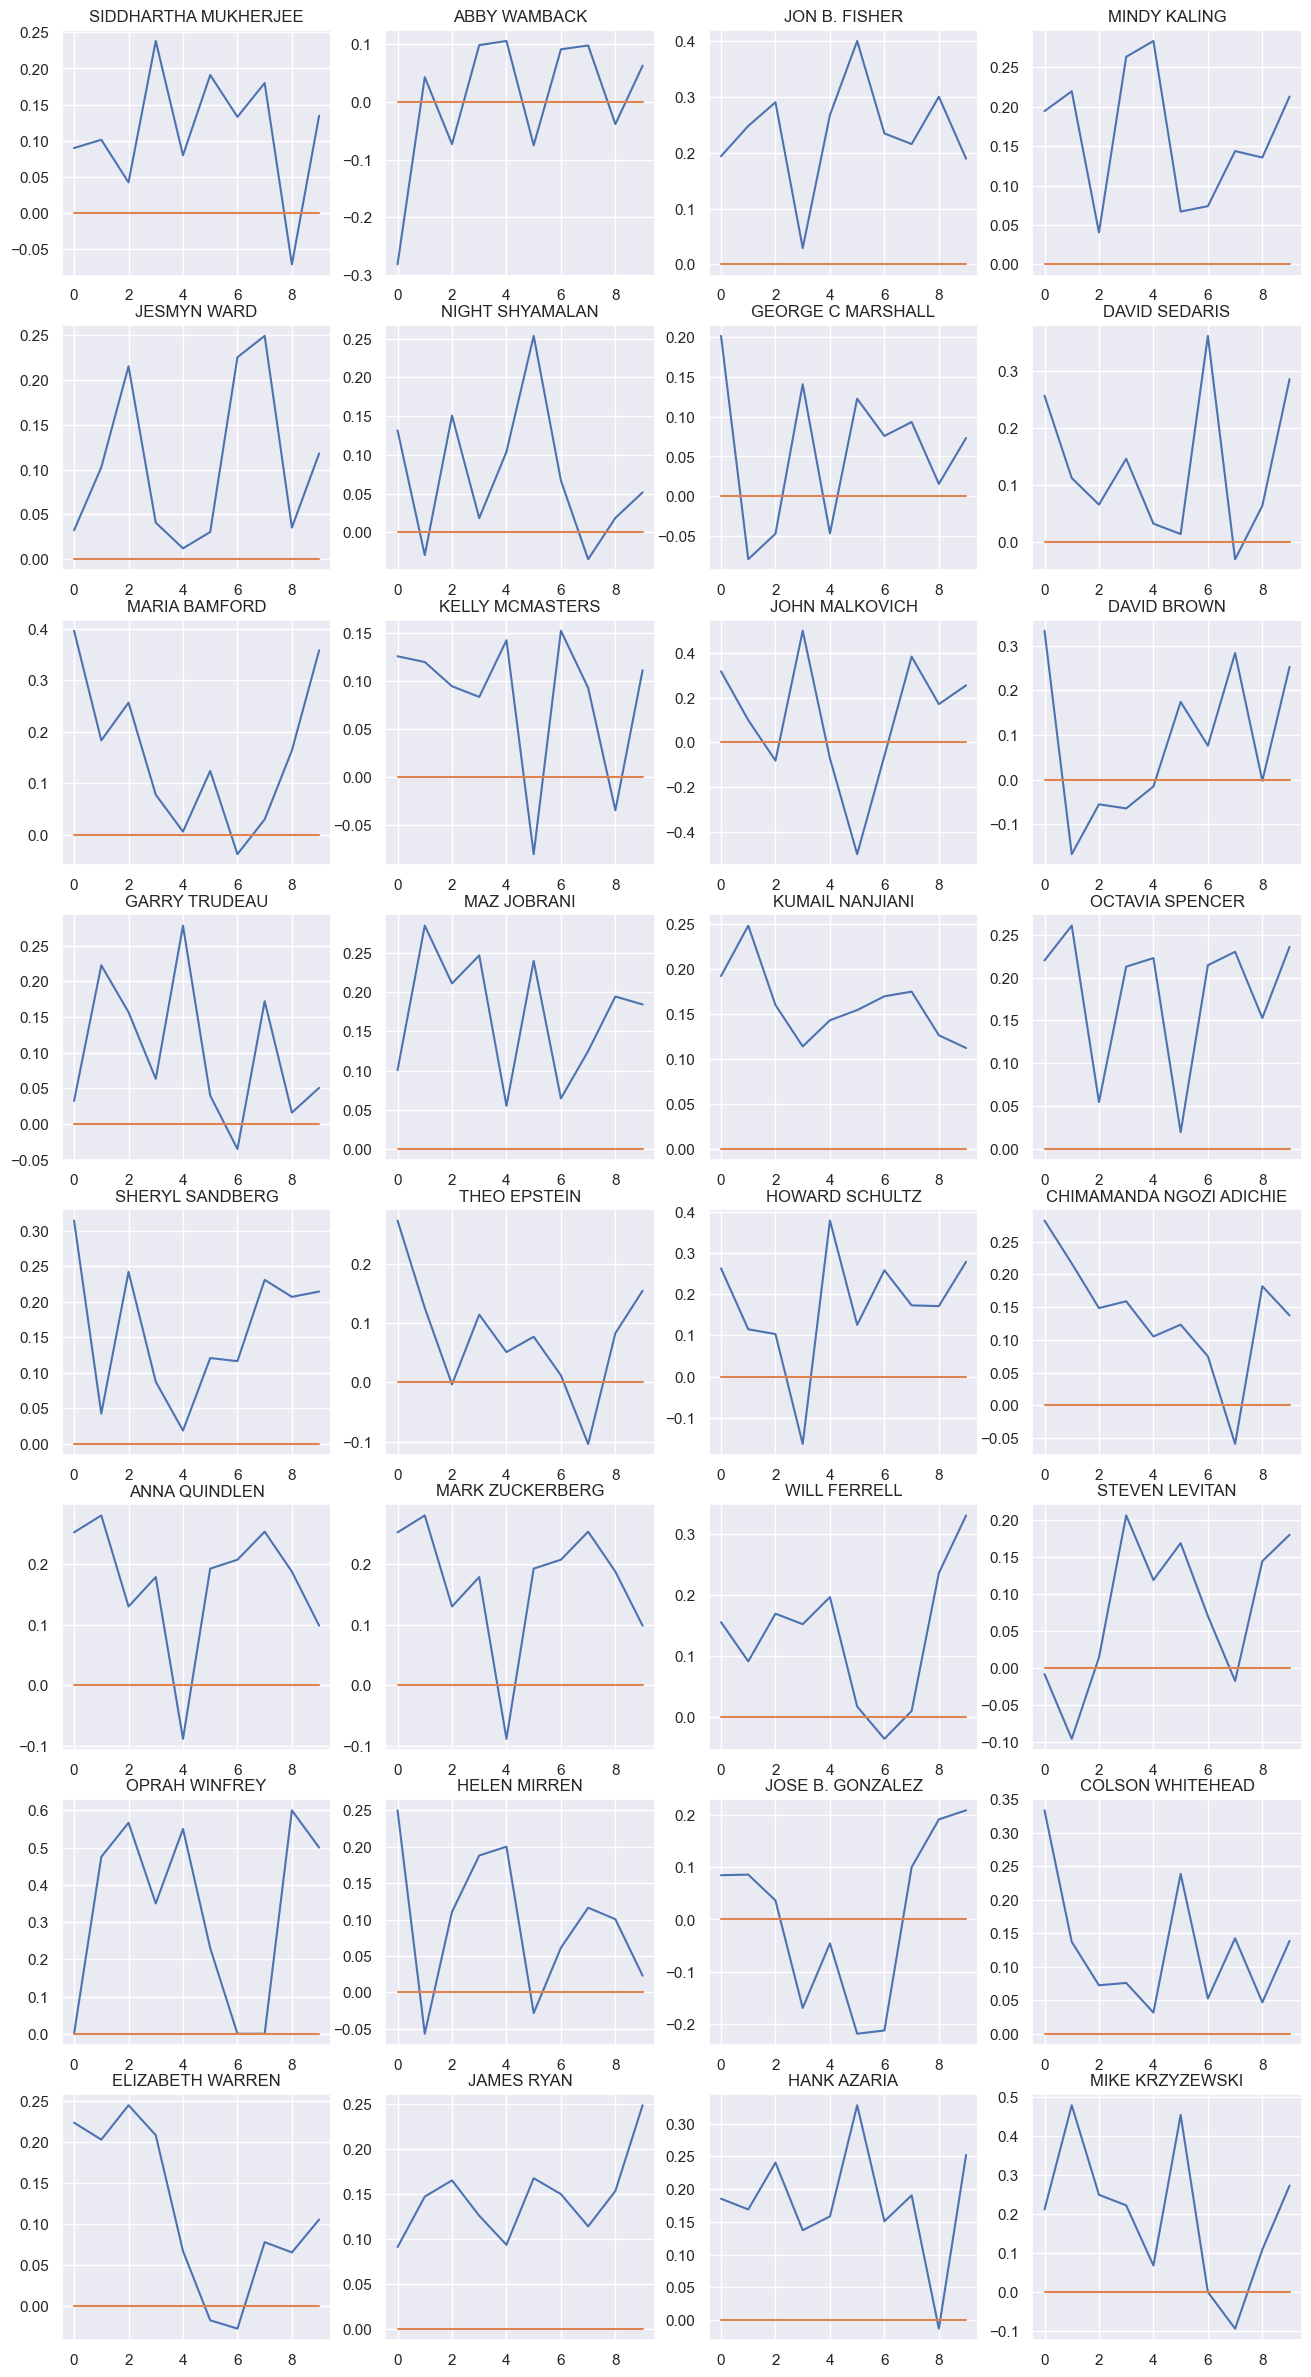

In [234]:
# Show the plot for all speeches
plt.rcParams['figure.figsize'] = [16, 30]

num_speech=32
for index, speech in enumerate(data.iloc[:num_speech].index):    
    plt.subplot(num_speech//4, 4, index+1)
    plt.plot(polarity_transcript[index])
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(data['speaker'][index])
#     plt.ylim(ymin=-.5, ymax=.5)
    
plt.show()

In [ ]:
# Comparison of VADER and TextBlob:
# Looks like 'compound' of VADER shows a more consistent trend among all speeches, which is,
# high opening and ending, with one or two dips in the middle.